# **INTRODUCTION TO PROBABILISTIC GRAPHICAL MODELS**

## PRACTICAL SESSION 2: GAUSSIAN MIXTURE MODELS

### Students
##### **GHRIBI SAIF EDDINE**
##### **GOMEZ ENRIQUE**

In [0]:
import numpy as np
import numpy.random as nrand
import random
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Question 1

During the expectation phase of our algorithm, we need to compute

$$
\gamma_i(x_n) = \frac{\pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum_{i=1}^{K} \pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i)}
$$

However, it is easier, faster and safer to compute $\log{\gamma_i(x_n)}$. Then,

$$
\log{\gamma_i(x_n)} = \log(\pi_i) -\frac{k}{2}\log(2\pi) -\frac{1}{2}\log{|\Sigma_i|} -\frac{1}{2}(x_n-\mu_i)^T\Sigma_i^{-1}(x_n-\mu_i) - \log{\sum_{i=1}^{K} \pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i)}
$$

There are two values which we should be careful with, $\log{|\Sigma_i|}$ and $\log{\sum_{i=1}^{K} \pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i)}$. The last expression can lead to overflow, so we apply the logsumexp trick of the last lab.

The first expression could lead to overflows as the data is so correlated, the determinant would be close to zero and could be approximated to this value. This will be evaluated as minus infinity by the log function.

So we use an equivalent of the matrix, taking advantage of its symetry and that it is positive definite. We can factorize it using Cholesky decomposition in two triangular matrices such that $\Sigma_i = LU$ where $L=U^T$.

So $|\Sigma_i| = |LU| = |LL^T| = |L|^2$ which is equal to the square of product of the diagonal term as the matrix is triangular. So, applying the log gives

$$
\log{(|\Sigma_i|)} = 2 \sum_{i=1}^{K} \log{L_{ii}} 
$$

where $L_{ii}$ is a term of the diagonal. 

In [0]:
def logsumexp(v):
  v_max=np.max(v)
  return  v_max+np.log(np.sum([np.exp(i- v_max )for i in v]))

In [0]:
def log_det(sigma):
  g = np.linalg.cholesky(sigma)
  diag_g = np.diag(g) 
  return 2  * np.sum(np.log(diag_g))

In [0]:
def num(X,pi,mu,sigma):
  num = []
  d = X.shape[1]
  for (pi_i,mu_i,sigma_i) in zip(pi,mu,sigma):
    sigma_inverse = np.linalg.pinv(sigma_i)
    num_i=[]
    for x_i in X:
      x_i = np.reshape(x_i , (1,d))
      s = np.log(pi_i) -0.5*d*np.log(2*np.pi)  -0.5*log_det(sigma_i) -0.5* (x_i - mu_i) @ sigma_inverse  @ (x_i- mu_i).T 
      num_i.append(s)
      
    num.append(num_i)
  return np.reshape(num,(len(sigma),X.shape[0]))


In [0]:
def compute_gamma(X,mu,sigma,pi):
  result = []
  n = num(X,pi,mu,sigma)
  for i in range(n.shape[1]) :
    result.append(n[:,i] - logsumexp(n[:,i]))
  result = np.array(result).T
  return result 


Let's test gamma

In [320]:
pi = np.array([0.3, 0.2, 0.5])
mu = np.array([[0,0], [1,2], [2,0]])
sigma = [[[1, -.25], [-.25, .5]],
         [[.5, .25], [.25, .5]],
         [[.5, -.25],[-.25,1]]]

#let take any X to test gamma(a vector of gamma_i)
X=np.array([[1,2],[3,4],[5,6]])

compute_gamma(X,mu,sigma,pi)

array([[-6.45942824e+00, -2.49717403e+01, -5.12562791e+01],
       [-1.55530129e-01, -1.17552403e-03, -4.08116918e-09],
       [-1.94860261e+00, -6.74662896e+00, -1.93168820e+01]])

#Question 2

### Question 2

Our goal is to maximize the probability of each data sample of the data set:

$$ \operatorname*{argmax}_{\mu,\Sigma,\pi} \{p(x_n) = \sum_{i=1}^{K} \pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i) \} $$

After the expectation step, we get an equivalent problem which leads us to the same parameters $\mu,\Sigma,\pi$. In that regard, we set a different loss function to optimize and compute the parameters to get the maximum likelihood.

So, our new problem after the E-step is, for each $x_n \in \mathbb{R}^{d}$ and $\gamma_i(x_n)$ defined in the Lab text

$$ \operatorname*{argmax}_{\mu \in {R}^{d\times K} ,\Sigma \in {M}^{d\times d \times K},\pi \in {R}^{K}} \{L(\mu,\Sigma,\pi) = \sum_{i=1}^{K} \sum_{n=1}^{N}\gamma_i(x_n)\log{(\pi_i \mathcal{N}(x_n;\mu_i,\Sigma_i))} \} $$

This problem is equivalent to

$$ \operatorname*{argmax}_{\pi \in {R}^{K}}\operatorname*{argmax}_{\mu \in {R}^{d\times K}}\operatorname*{argmax}_{\Sigma \in {M}^{d\times d \times K}} \{L(\mu,\Sigma,\pi) = \sum_{n=1}^{N}\gamma(x_n)\log{(\pi \mathcal{N}(x_n;\mu,\Sigma))} \} $$

This function is the composition of two concave functions. It is therefore concave, and its global maximum is reached at the point when its gradient makes zero. So, let us compute the gradient of $L_i$ w.r.t to each parameter, we will use the linearity of the differentiation the most of the cases.

This problem is separable w.r.t the indices k for $\mu$ and $\Sigma$, so this is equivalent to solve our new loss function $L_i$ for $i \in {1..K}$ when optimizing $\mu$ and $\Sigma$.  It is important to remark that it is possible to remove the sum with $\pi$ as it is involved in the opmitization of the loglikehood with respect with $\mu$ and $\Sigma$.

$$ \operatorname*{argmax}_{\mu_i \in {R}^{d}}\operatorname*{argmax}_{\Sigma_i \in {M}^{d\times d}} \{L_i(\mu_i,\Sigma_i) = \sum_{n=1}^{N}\gamma_i(x_n)\log{(\mathcal{N}(x_n;\mu_i,\Sigma_i))} \} $$

The derivative over $\mu_i$ is :

$$  \frac{\partial L_i}{\partial \mu_i} = \sum_{n=1}^{N}\frac{\partial}{\partial \mu_i} \gamma_i(x_n)[ \frac{1}{2}\log{|\Sigma_i|}-\frac{1}{2}(x_n-\mu_i)^T\Sigma_i^{-1}(x_n-\mu_i)]) = \sum_{n=1}^{N} -\gamma_i(x_n)\frac{1}{2}2\Sigma_i^{-1}(x_n - \mu_i)$$

When setting the derivative to zero, and supposing that $\Sigma$ is positive definite, we get the optimum value of $\mu_i$ which is

$$
\mu_i^* =  \frac{\sum_{n=1}^N \gamma_i(x_n) x_n }{\sum_{n=1}^N \gamma_i(x_n) } 
$$


The derivative over $\Sigma_i$, which is symetric, is :

$$  \frac{\partial L_i(\theta)}{\partial \Sigma_i} = \sum_{n=1}^{N}\frac{\partial}{\partial \Sigma_i} \gamma_i(x_n)[ \frac{1}{2}\log{|\Sigma_i|}-\frac{1}{2}(x_n-\mu_i)^T\Sigma_i^{-1}(x_n-\mu_i)]) = \sum_{n=1}^{N} \gamma_i(x_n)[-\frac{1}{2}\frac{1}{|\Sigma_i|}|\Sigma_i|(\Sigma_i^{-1})^T + \frac{1}{2}\Sigma_i^{-1}\Sigma_i^{-1}(x_n-\mu_i)^T(x_n-\mu_i) ] = \sum_{n=1}^{N} \gamma_i(x_n)[-\frac{1}{2}\Sigma_i^{-1} + \frac{1}{2}\Sigma_i^{-1}\Sigma_i^{-1}(x_n-\mu_i)^T(x_n-\mu_i) ]$$

It is important to highlight that we used the following results which we will not show. 
Let $A$ an invertible matrix and $|A|$ its determinant

$$
\frac{\partial |A|}{\partial A} = |A|(A^{-1})^T
$$
$$
\frac{\partial A^{-1}}{\partial A} = -A^{-1}A^{-1}
$$

When setting the derivative to zero, and supposing that $\Sigma$ is positive definite, we get the optimum value of $\Sigma_i$ which is

$$
\Sigma_i^* =  \frac{\sum_{n=1}^N \gamma_i(x_n) (x_n-\mu_i)(x_n-\mu_i)^T}{\sum_{n=1}^N \gamma_i(x_n)}
$$


Finally, the optimum $\pi$ has to satisfy the contraint $\sum_{k=1}^K \pi_i = 1$ as they represent probabilities. So our problem to maxime $\pi$

$$ \operatorname*{argmax}_{\pi \in {R^K}, \sum_{k=1}^K \pi_i = 1} \{\sum_{n=1}^{N}\sum_{i=1}^{K}\gamma_i(x_n)\log{(\pi_i )}\} $$

Using Lagrange multipliers, we can write our problem in this way

$$ \operatorname*{argmax}_{\pi \in {R^K}} \{\sum_{n=1}^{N}\sum_{i=1}^{K}\gamma_i(x_n)\log{(\pi_i )} + \lambda(\sum_{k=1}^K \pi_i-1)\} $$

Taking the derivative of the objective function wrt each element of $\pi$
$$
\frac{\partial}{\partial \pi_i} \sum_{n=1}^{N}\sum_{i=1}^{K}\gamma_i(x_n)\log{(\pi_i )} + \lambda(\sum_{k=1}^K \pi_i-1)\} = \sum_{n=1}^{N}\frac{\gamma_i(x_n)}{\pi_i} + \lambda
$$

So, setting the derivative to 0, we get

$$
\pi^*_i = -\sum_{n=1}^{N}\frac{\gamma_i(x_n)}{\lambda}
$$

But $\sum_{k=1}^K \pi^*_i =1$. So $\lambda = -N$ and therefore

$$
\pi^*_i = \sum_{n=1}^{N}\frac{\gamma_i(x_n)}{N}
$$

Those optima give the update for each parameter after each iteration.

# Question 3

## Question 3.1)

In [0]:
def data_set(N,K,pi,mu,sigma):   
  r=np.random.multinomial(1, pvals=pi, size=N)
  norm = []
  for i in range (K):
    norm.append(np.random.multivariate_normal(mu[i], sigma[i], N))
  X=[]
  C=[]
  for i in range (N) : 
    idx =  np.argmax(r[i])
    X.append([ norm[idx][i,:][0],norm[idx][i,:][1] ])
    C.append(idx)
    # C is a list of the classes of the data 
  return np.array(X),C
    

Text(0.5, 1.0, 'X visualization')

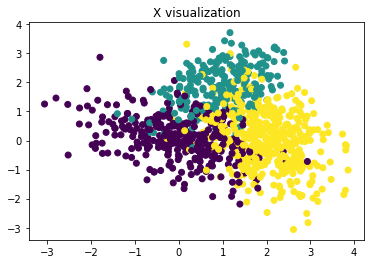

In [322]:
N = 1000
K = 3
X,c = data_set(N, K, pi, mu, sigma)
plt.scatter(X[:,0],X[:,1],c=c)
plt.title("X visualization")

## Question 3.2)

In [0]:
def loglikelihood(X,mu,sigma,pi):
    tot_sum = 0
    for n in range(X.shape[0]):
        partial_sum = 0
        for k in range(len(pi)):
            partial_sum += pi[k] * multivariate_normal.pdf(X[n,:],mean=mu[k,:],cov=sigma[k],allow_singular=True)
        tot_sum += np.log(partial_sum)
    return tot_sum
def calc_err(mu,sigma,pi):
  pi_gt = np.array([0.3, 0.2, 0.5])
  mu_gt = np.array([[0,0], [1,2], [2,0]])
  sigma_gt = [[[1, -.25], [-.25, .5]],
         [[.5, .25], [.25, .5]],
         [[.5, -.25],[-.25,1]]]
  err = np.linalg.norm(mu-mu_gt) + np.linalg.norm(sigma-sigma_gt) + np.linalg.norm(pi-pi_gt)
  return err

In [0]:
  
def GMM(X, K,mu_0,sigma_0,pi_0,n_iter = 100, eps = 1e-2,verbose = True):
    n = X.shape[0] 
    d = X.shape[1]
    sigma = sigma_0.copy()
    mu = mu_0.copy()
    pi = pi_0.copy()
    sigma_arr = [sigma.copy()]
    mu_arr = [mu.copy()]
    pi_arr = [pi.copy()]
    l = loglikelihood(X,mu,sigma,pi)
    num_classes = K    
    it = 0
    error = 1
    loglik = []
    while it <  n_iter and error > eps:
        # E-step
        gamma = np.exp(compute_gamma(X,mu,sigma,pi))
        
        # M-step
        for  k in range(num_classes):  
          
            N_k = np.sum(gamma[k])
            
            mu[k,:] = gamma[k] @ X / N_k
            
            sigma_new = np.zeros((d,d))
            for j in range(len(gamma[k])) :
                a = np.reshape(X[j,:]-mu[k,:],(d,1))
                sigma_new += gamma[k][j] * a @ a.T 
            sigma[k] = sigma_new /N_k
            pi[k] = N_k / n
          
        loglik.append(loglikelihood(X,mu,sigma,pi))
        error = np.linalg.norm(l - loglik[-1])
        
        err = calc_err(mu,sigma,pi)
        if (it%20 ==0):
          sigma_arr.append(sigma)
          mu_arr.append(mu)
          pi_arr.append(pi)
          if (verbose ):
            print("Epoch: ",it+20," ---- Error: ",error)
            print("Sum of Pi = ",np.sum(pi))
        l = loglik[-1]
        it += 1
    sigma_arr.append(sigma)
    mu_arr.append(mu)
    pi_arr.append(pi)
    return  mu_arr, sigma_arr, pi_arr ,loglik
    
  

In [325]:
K = 3
n = X.shape[0] 
d = X.shape[1]
pi_0 = np.random.rand(K,1)
pi_0 = pi/np.sum(pi)
mu_0 = np.random.rand(K,d) - 0.5
s = np.random.rand(K,d,d)
sigma_0 = np.array([ s[i,:,:].T @ s[i,:,:] for i in range(s.shape[0])])
mu_g, sigma_g, pi_g,loglik = GMM(X, K,mu_0,sigma_0,pi_0,n_iter = 100, eps = 1e-10)


Epoch:  20  ---- Error:  1936.979751747133
Sum of Pi =  1.0
Epoch:  40  ---- Error:  0.24440868219653566
Sum of Pi =  1.0
Epoch:  60  ---- Error:  0.031067932830865175
Sum of Pi =  1.0
Epoch:  80  ---- Error:  0.003938614517664973
Sum of Pi =  0.9999999999999999
Epoch:  100  ---- Error:  0.0006815355495746189
Sum of Pi =  1.0


The algorithm converges and everything seem to work,let's test it further in the next questions

### Question 3.2.a)

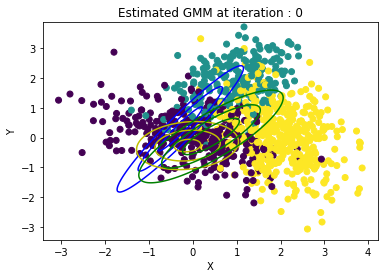

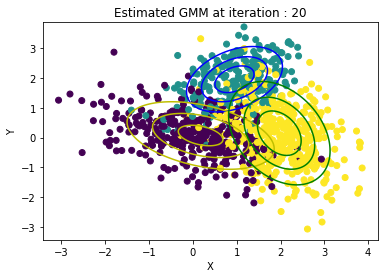

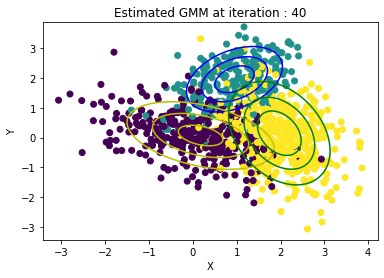

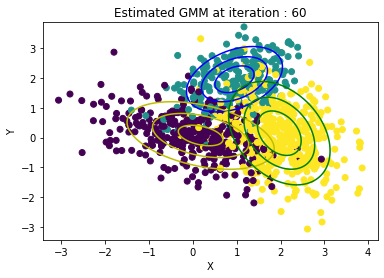

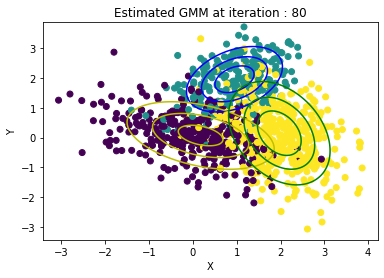

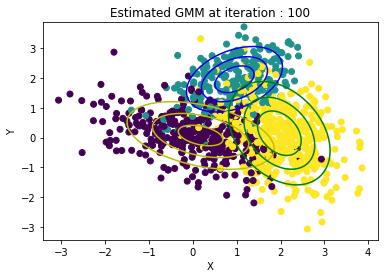

In [326]:
K = 3
min_x_0 = np.min(X[:,0])
max_x_0 = np.max(X[:,0])
min_x_1 = np.min(X[:,1])
max_x_1 = np.max(X[:,1])

y = np.linspace(min_x_0,max_x_0,500)
x = np.linspace(min_x_1,max_x_1,500)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.array([X_grid.flatten(),Y_grid.flatten()]).T
col = ['b','y','g']
for i in range(len(mu_g)-1):
  fig2 = plt.figure()
  ax2 = fig2.add_subplot(111)
  ax2.scatter(X[:,0], X[:,1], c = c)
  ax2.set_title('Estimated GMM at iteration : ' + str(i*20))
  ax2.set_xlabel("X")
  ax2.set_ylabel("Y")
  rv = []
  for t in range(K):
    rv.append(multivariate_normal(mu_g[i][t], sigma_g[i][t]))
    ax2.contour(X_grid, Y_grid, pi_g[i][t]*rv[t].pdf(pos).reshape(500,500), levels = 3, colors = col[t])


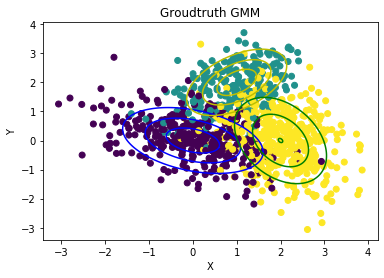

In [327]:
## Ground Truth
K = 3
min_x_0 = np.min(X[:,0])
max_x_0 = np.max(X[:,0])
min_x_1 = np.min(X[:,1])
max_x_1 = np.max(X[:,1])

x = np.linspace(min_x_0,max_x_0,500)
y = np.linspace(min_x_1,max_x_1,500)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.array([X_grid.flatten(),Y_grid.flatten()]).T
col = ['b','y','g']
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(X[:,0], X[:,1], c = c)

ax2.set_title('Groudtruth GMM')
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
rv = []
for t in range(K):
  rv.append(multivariate_normal(mu[t], sigma[t]))
  ax2.contour(X_grid, Y_grid, pi[t]*rv[t].pdf(pos).reshape(500,500), levels = 3, colors = col[t])

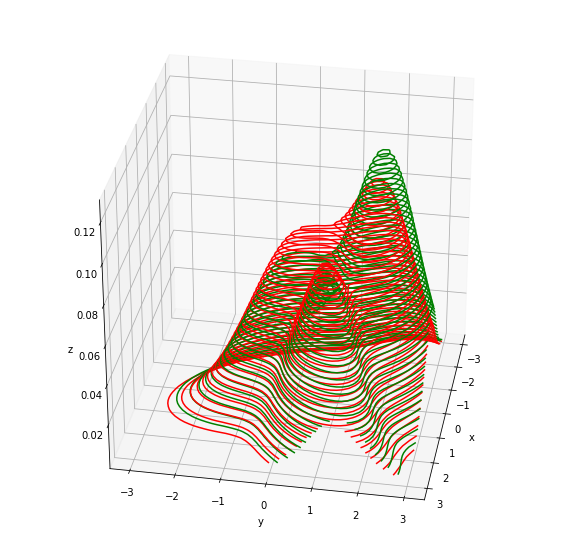

In [328]:
K = 3
x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)

X_, Y_ = np.meshgrid(x, y)

Z_gt=[]
Z_=[]

for x_ in x:
    arr = []
    for y_ in y:
        sum_ = 0
        for k in range(K):
            sum_ += pi[k] * multivariate_normal.pdf([x_,y_],mean=mu[k],cov=sigma[k],allow_singular=True)
        arr.append(sum_)
    Z_gt.append(arr)

Z_gt = np.array(Z_gt)


for x_ in x:
    arr = []
    for y_ in y:
        sum_ = 0
        for k in range(K):
            sum_ += pi_g[-1][k] * multivariate_normal.pdf([x_,y_],mean=mu_g[-1][k,:],cov=sigma_g[-1][k,:,:],allow_singular=True)
        arr.append(sum_)
    Z_.append(arr)

Z_ = np.array(Z_)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(X_, Y_, Z_, 50,colors='r')
ax.contour3D(X_, Y_, Z_gt, 50,colors='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(31, 10)

plt.show()

### Comments:

It is pretty clear that the GMM converges and suggests a distribution of clusters . After only 20 epocs, the results are already good enough. Moreover,for some initial values  the contours are almost the same when we compare the distribution with the generated parameters and the groudtruth distribution.

In the above graph, the green surface represents the groundtruth distribution and the green the one generated with the learnt parameters. We can see that both are quite similar. The learnt one is a good estimation of the groundtruth.

### Question 3.2.b)

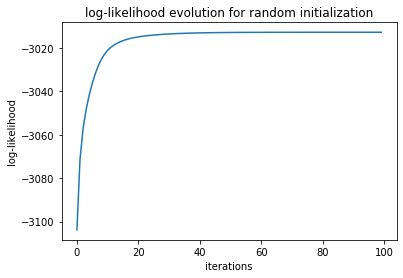

In [329]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(loglik)
ax3.set_title("log-likelihood evolution for random initialization")
ax3.set_xlabel("iterations")
ax3.set_ylabel("log-likelihood")
plt.show()

Our method aims to maximize the log-likehood. From the graph, we see that this goal is being achieve consistently and the maximization converges pretty quickly. In about 30 iterations, the algorithm almost converged.

### Question 3.2.c)

In [0]:
pi = np.array([0.3, 0.2, 0.5])
mu = np.array([[0,0], [1,2], [2,0]])
sigma = [[[1, -.25], [-.25, .5]],
         [[.5, .25], [.25, .5]],
         [[.5, -.25],[-.25,1]]]

GMM finished with the initial values :  1
GMM finished with the initial values :  2


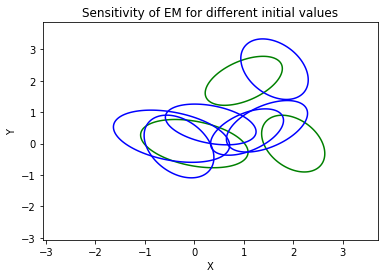

In [331]:
from matplotlib.pyplot import cm
min_x_0 = np.min(X[:,0])
max_x_0 = np.max(X[:,0])
min_x_1 = np.min(X[:,1])
max_x_1 = np.max(X[:,1])
fig2 = plt.figure()
ax2 = fig2
y = np.linspace(min_x_0,max_x_0,500)
x = np.linspace(min_x_1,max_x_1,500)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.array([X_grid.flatten(),Y_grid.flatten()]).T

num_essays = 2
K = 3

rv = []
for t in range(K):
  rv.append(multivariate_normal(mu[t], sigma[t]))
  plt.contour(X_grid, Y_grid, pi[t]*rv[t].pdf(pos).reshape(500,500), levels = 1, colors = "g")
for i in range(num_essays): 
  n = X.shape[0] 
  d = X.shape[1]
  pi_0 = np.random.rand(K,1)
  pi_0 = pi/np.sum(pi)
  mu_0 = np.random.rand(K,d) - 0.5
  s = np.random.rand(K,d,d)
  sigma_0 = np.array([ s[i,:,:].T @ s[i,:,:] for i in range(s.shape[0])])
  mu_g, sigma_g, pi_g,loglik = GMM(X, 3,mu_0,sigma_0,pi_0,n_iter = 20, eps = 1e-10,verbose = False)
  print("GMM finished with the initial values :  "+str(i+1))
  mu =mu_g[-1]
  pi = pi_g[-1]
  sigma_g = sigma_g[-1]
  K = 3    
  rv = []
  for t in range(K):
    rv.append(multivariate_normal(mu[t], sigma[t]))
    a = plt.contour(X_grid, Y_grid, pi[t]*rv[t].pdf(pos).reshape(500,500),levels =1 , colors = "b")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sensitivity of EM for different initial values")

plt.show()

  



The blue countours are the one computed by GMM and the green is the ground truth ,we can see obviously that the countours computed by GMM change if we change the initial values.GMM is then sensisitive to the initial values.